In [1]:
import yt 
import zarr 

yt.set_log_level(50) 

ts = yt.load("Enzo_64/DD????/data????")

pull out the filenames

In [2]:
fnames = [ds.filename for ds in ts]

build up the dask function

In [9]:
from pathlib import Path
import numpy as np 

def extract_particle_data(ds):
    flds = [f"particle_position_{ax}" for ax in "xyz"]
    flds += ['particle_index',]
    
    fld_rename = {fld: fld.replace('particle_','').replace('position_','') for fld in flds}
    fld_rename['particle_index']='track_id'
    particle_data = {}
    for fld in flds: 
        particle_data[fld_rename[fld]] = ds.r[:][('io', fld)]

    particle_data['track_id'] = particle_data['track_id'].astype(np.int64)
    return particle_data

def get_dataframe(ds, particle_data, t_index): 
    import pandas as pd 
        
    particle_data['parent_track_id'] = np.full(particle_data['x'].shape, -1, dtype=np.int8)
    particle_data['t'] = np.full(particle_data['x'].shape, t_index, dtype=np.int32)
    return pd.DataFrame(particle_data)
    

def write_data(ds, particle_data, t_index, save_dir):
    # first go: write intermediate csv then use the conversion scripts    
    
    out_fi = Path(save_dir) / Path(f"t_{t_index}.csv")    
    df = get_dataframe(ds, particle_data, t_index) 
    df.to_csv(out_fi, index=False)
    
    
def sample_timestep(ds_fname, t_index, save_dir):
    yt.set_log_level(50)    
    
    # load the current ds
    ds = yt.load(ds_fname)

    # get the data
    particle_data = extract_particle_data(ds)
    
    # write the data. 
    write_data(ds, particle_data, t_index, save_dir)
    
    return particle_data['track_id'].size

In [10]:
import dask 
n_particles_v_time = [] 
save_dir = Path(yt.config.ytcfg.get('yt', 'test_data_dir')) / 'enzo_64_csv_temp'

if not save_dir.is_dir():
    save_dir.mkdir() 

# could use a distributed dask dataframe instead... meh. 
for ifile, fname in enumerate(fnames):
    n_particles_v_time.append(dask.delayed(sample_timestep)(fname, ifile, save_dir))

In [11]:
from dask.distributed import Client

In [6]:
c = Client(threads_per_worker=2, n_workers=4)

In [7]:
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 31.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39127,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 31.18 GiB
Comm: tcp://127.0.0.1:38267,Total threads: 2
Dashboard: http://127.0.0.1:36105/status,Memory: 7.80 GiB
Nanny: tcp://127.0.0.1:33283,


In [12]:
n_particles_v_time = dask.compute(*n_particles_v_time)

Parsing Hierarchy : 100%|██████████| 695/695 [00:00<00:00, 3363.84it/s]


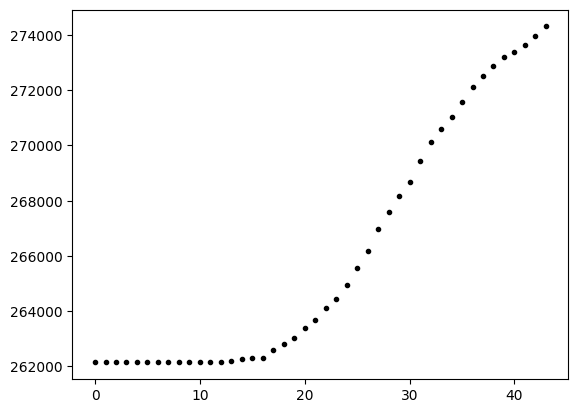

In [13]:
import matplotlib.pyplot as plt 
plt.plot(n_particles_v_time,'.k')

In [14]:
c.close()

concatenate all those files... 

In [22]:
import os 
import pandas as pd 

df_list = []

full_file = 'full_timeseries.csv'
for fname in os.listdir(save_dir):
    if fname == full_file:
        pass 

    df_list.append(pd.read_csv(save_dir / fname))

df_full = pd.concat(df_list, ignore_index=True, sort=False)
df_full = df_full.sort_values('track_id')
df_full.to_csv(save_dir / full_file, index=False)

In [23]:
save_dir / full_file

PosixPath('/home/chavlin/hdd/data/yt_data/yt_sample_sets/enzo_64_csv_temp/full_timeseries.csv')

Now go use other conversion tool... 

```
python convert_tracks_csv_to_sparse_zarr.py --help

usage: convert_tracks_csv_to_sparse_zarr.py [-h] [--add_radius]
                                            csv_file [out_dir]

Convert a CSV of tracks to a sparse Zarr store

positional arguments:
  csv_file      Path to the CSV file
  out_dir       Path to the output directory (optional, defaults to the parent
                dir of the CSV file)

```



```
$ python convert_tracks_csv_to_sparse_zarr.py /home/chavlin/hdd/data/yt_data/yt_sample_sets/enzo_64_csv_temp/full_timeseries.csv /home/chavlin/hdd/data/yt_data/yt_sample_sets/enzo_64_csv_temp/zarr_formatted/
```
outputs:

```shell
full_timeseries.csv /home/chavlin/hdd/data/yt_data/yt_sample_sets/enzo_64_csv_temp/
add_radius False
num_values_per_point (z,y,x,radius) 3
3D dataset
Read 23415576 points in 50.60304679116234 seconds
Warning: track_ids not consecutive (274305 track_IDs found, max track_id = 274304)
Solution: Track_id are reformatted to be consecutive from 1 to N, with N the number of tracks
Munged 23415576 points in 91.01697052596137 seconds
Chased track lineage forward in 0.004794452805072069 seconds (0 iterations)
Chased track lineage backward in 0.0025953189469873905 seconds (0 iterations)
Converted to CSR in 19.74572199070826 seconds
Saved to Zarr in 26.30006174184382 seconds
```

could fix that track id 0-indexing but whatever..


Now we want to serve the new zarr:

In [27]:
save_dir / 'zarr_formatted' / 'full_timeseries_bundle.zarr'

PosixPath('/home/chavlin/hdd/data/yt_data/yt_sample_sets/enzo_64_csv_temp/zarr_formatted/full_timeseries_bundle.zarr')

```
python serve_directory_http.py --help
usage: Serves data on the file system over HTTP bypassing CORS [-h] [--host HOST] [--port PORT] dir

positional arguments:
  dir          The directory on the filesystem to serve
```

so 

```
python serve_directory_http.py /home/chavlin/hdd/data/yt_data/yt_sample_sets/enzo_64_csv_temp/zarr_formatted/full_timeseries_bundle.zarr
```

```shell
INFO:root:Serving /home/chavlin/hdd/data/yt_data/yt_sample_sets/enzo_64_csv_temp/zarr_formatted/full_timeseries_bundle.zarr at http://127.0.0.1:8000
```

now up in the app directory

```
npm run dev
```

then click the little world icon and enter the local address `http://127.0.0.1:8000`